# CAS KAGGLE: Anlàlisi de dades d'escacs

https://www.kaggle.com/datasnaek/chess

### Naroa Sarrià 1706167, Inés Gómez 1704361

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from scipy.stats import gaussian_kde
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, make_scorer, roc_curve, auc, precision_recall_curve, classification_report, confusion_matrix, ConfusionMatrixDisplay, average_precision_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold
from time import time

%matplotlib inline
sns.set_style('whitegrid')

## 1. EDA (Exploratory Data Analysis)

Carreguem el nostre dataset per veure com son les nostres dades i, posteriorment, veure les dimensions i el tipus de variables.

In [2]:
df = pd.read_csv("games.csv")
df.head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


In [3]:
print("Dimensions:", df.shape)
df.info()


Dimensions: (20058, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              20058 non-null  object 
 1   rated           20058 non-null  bool   
 2   created_at      20058 non-null  float64
 3   last_move_at    20058 non-null  float64
 4   turns           20058 non-null  int64  
 5   victory_status  20058 non-null  object 
 6   winner          20058 non-null  object 
 7   increment_code  20058 non-null  object 
 8   white_id        20058 non-null  object 
 9   white_rating    20058 non-null  int64  
 10  black_id        20058 non-null  object 
 11  black_rating    20058 non-null  int64  
 12  moves           20058 non-null  object 
 13  opening_eco     20058 non-null  object 
 14  opening_name    20058 non-null  object 
 15  opening_ply     20058 non-null  int64  
dtypes: bool(1), float64(2), int64(4), object(9)
memory u

Ara mirem si tenim variables NaN's a les dades

In [4]:
df.isna().mean().sort_values(ascending=False)

id                0.0
rated             0.0
created_at        0.0
last_move_at      0.0
turns             0.0
victory_status    0.0
winner            0.0
increment_code    0.0
white_id          0.0
white_rating      0.0
black_id          0.0
black_rating      0.0
moves             0.0
opening_eco       0.0
opening_name      0.0
opening_ply       0.0
dtype: float64

Com veiem, no tenim missing values a les dades, per tant mirem estadísticament les dades

In [5]:
df.describe()

,created_at,last_move_at,turns,white_rating,black_rating,opening_ply
count,2.005800e+04,2.005800e+04,20058.000000,20058.000000,20058.000000,20058.000000
mean,1.483617e+12,1.483618e+12,60.465999,1596.631868,1588.831987,4.816981
std,2.850151e+10,2.850140e+10,33.570585,291.253376,291.036126,2.797152
min,1.376772e+12,1.376772e+12,1.000000,784.000000,789.000000,1.000000
25%,1.477548e+12,1.477548e+12,37.000000,1398.000000,1391.000000,3.000000
50%,1.496010e+12,1.496010e+12,55.000000,1567.000000,1562.000000,4.000000
75%,1.503170e+12,1.503170e+12,79.000000,1793.000000,1784.000000,6.000000
max,1.504493e+12,1.504494e+12,349.000000,2700.000000,2723.000000,28.000000


Analitzem ara la nostre variable target, el guanyador de la partida, per veure la seva distribució i per tant per veure també si està balancejada

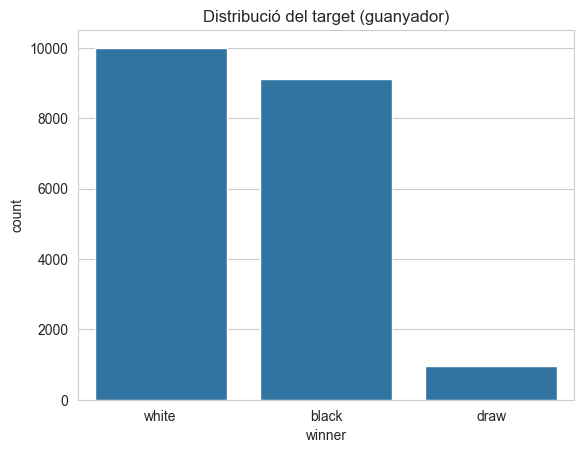

winner
white    0.498604
black    0.454033
draw     0.047363
Name: proportion, dtype: float64

In [6]:
sns.countplot(data=df, x="winner")
plt.title("Distribució del target (guanyador)")
plt.show()

df["winner"].value_counts(normalize=True)

Ara analitzem les variables de ratings, per veure la seva distribució

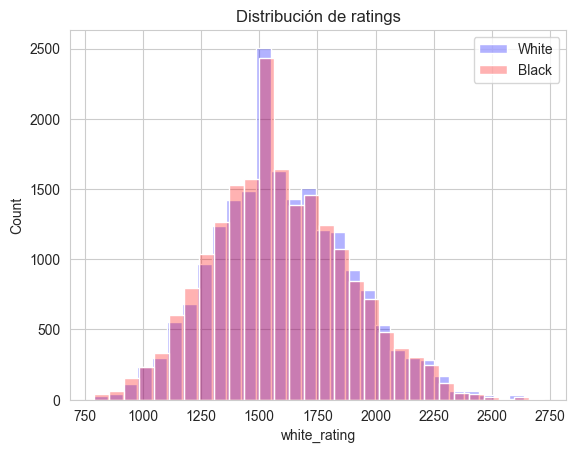

In [7]:
sns.histplot(df["white_rating"], bins=30, color="blue", alpha=0.3, label="White")
sns.histplot(df["black_rating"], bins=30, color="red",  alpha=0.3, label="Black")
plt.title("Distribución de ratings")
plt.legend()
plt.show()

Observem també ràpidament les apertures, per veure quants tipus en tenim i quines son les que mes es repeteixen. Com veiem que hi han masses tipus d'apertures diferents, les agruparem pel tipus d'apertura (no el seu codi propi), les agruparem segons si comencen per A, B, C, D, E (EXPLICAR BIEN PORQUE Y QUE ES CADA)

In [8]:
df["opening_name"].value_counts()

opening_name
Van't Kruijs Opening                                                  368
Sicilian Defense                                                      358
Sicilian Defense: Bowdler Attack                                      296
French Defense: Knight Variation                                      271
Scotch Game                                                           271
                                                                     ... 
Slav Defense: Two Knights Attack                                        1
Sicilian Defense: Richter-Rauzer Variation |  Vitolins Variation        1
Queen's Gambit Declined: Exchange Variation |  Reshevsky Variation      1
Neo-Gruenfeld Defense: Classical Variation |  Polgar Variation          1
Slav Defense: Diemer Gambit                                             1
Name: count, Length: 1477, dtype: int64

In [9]:
df["opening_eco"].value_counts()

opening_eco
A00    1007
C00     844
D00     739
B01     716
C41     691
       ... 
D58       1
C32       1
E18       1
D95       1
D22       1
Name: count, Length: 365, dtype: int64

CORRELACIONES¿?¿? DESPUES

## Preprocessing + Feature Engineering

Primer codifiquem el nostre target (winner) per tenir-lo com a 0 (white), 1 (black) i 2 (draw)

In [10]:
df['winner'] = df['winner'].replace({'white': 1, 'black': -1, 'draw': 0})

C:\Users\nsarr\AppData\Local\Temp\ipykernel_12272\1610047825.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['winner'] = df['winner'].replace({'white': 1, 'black': -1, 'draw': 0})


Com hem vist a l'apartat anterior, no tenim cap calor NaN a les dades, per tant, passem a crear la variable diff_rating que serà la diferència entre els ratings dels dos jugadors (white_rating - black_rating)

In [11]:
df["diff_rating"] = df["white_rating"] - df["black_rating"]
df.head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply,diff_rating
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,1,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5,309
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,-1,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4,61
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,1,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3,-4
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,1,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3,-15
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,1,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5,54


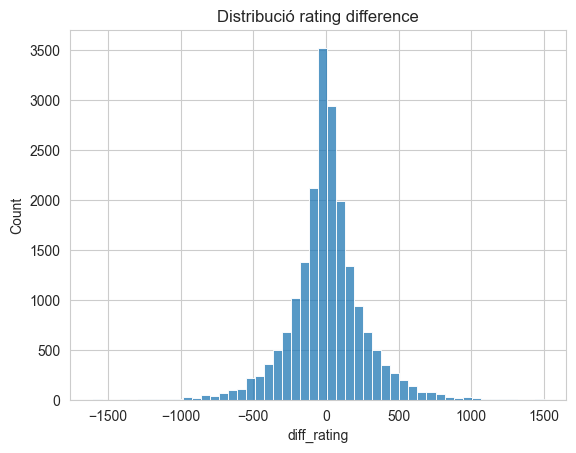

In [12]:
sns.histplot(df["diff_rating"], bins=50)
plt.title("Distribució rating difference")
plt.show()

Treballem ara amb les variables de "historial" (amb les dates) entre jugadors per així tenir registre de:
* Quantes vegades el blanc ha guanyat a aquest rival abans
* Quantes vegades el negre ha guanyat a aquest rival abans
* I una variable de si han jugat préviament o no (1 si han jugat abans, 0 si es la primera vegada)

In [13]:
"""
# Asegurar que la fecha esté en formato datetime
df['created_at'] = pd.to_datetime(df['created_at'], unit='ms')

# Ordenar por fecha para mantener el orden temporal
df = df.sort_values('created_at')

# Diccionario para guardar el historial de victorias por pareja
# Estructura:
# history[(player1, player2)] = {"player1_as_white": n, "player2_as_white": m}
history = {}

# Listas para almacenar resultados
white_prev_wins_vs_black = []
black_prev_wins_vs_white = []
played_before = []

for _, row in df.iterrows():
    white = row["white_id"]
    black = row["black_id"]
    winner = row["winner"]  # 0 = white, 1 = black, 2 = draw

    # Crear key de la pareja **sin importar el orden**
    pair = tuple(sorted([white, black]))
    
    # Inicializar historial si no existe
    if pair not in history:
        history[pair] = {"player1_as_white": 0, "player2_as_white": 0}
        white_prev_wins_vs_black.append(0)
        black_prev_wins_vs_white.append(0)
        played_before.append(0)
    else:
        # Saber cuál jugador es player1 y player2 en la key
        p1, p2 = pair
        if white == p1:
            white_prev_wins_vs_black.append(history[pair]["player1_as_white"])
            black_prev_wins_vs_white.append(history[pair]["player2_as_white"])
        else:
            white_prev_wins_vs_black.append(history[pair]["player2_as_white"])
            black_prev_wins_vs_white.append(history[pair]["player1_as_white"])
        played_before.append(1)

    # Actualizar historial según quién ganó
    if winner == 1:  # blanco 
        if white == pair[0]:
            history[pair]["player1_as_white"] += 1
        else:
            history[pair]["player2_as_white"] += 1
    elif winner == -1:  # negro 
        if black == pair[0]:
            history[pair]["player1_as_white"] += 1
        else:
            history[pair]["player2_as_white"] += 1
    # empate (0) → no se incrementa nada

# Agregar las nuevas columnas al DataFrame
df["white_prev_wins_vs_black"] = white_prev_wins_vs_black
df["black_prev_wins_vs_white"] = black_prev_wins_vs_white
df["played_before"] = played_before
"""

'\n# Asegurar que la fecha esté en formato datetime\ndf[\'created_at\'] = pd.to_datetime(df[\'created_at\'], unit=\'ms\')\n\n# Ordenar por fecha para mantener el orden temporal\ndf = df.sort_values(\'created_at\')\n\n# Diccionario para guardar el historial de victorias por pareja\n# Estructura:\n# history[(player1, player2)] = {"player1_as_white": n, "player2_as_white": m}\nhistory = {}\n\n# Listas para almacenar resultados\nwhite_prev_wins_vs_black = []\nblack_prev_wins_vs_white = []\nplayed_before = []\n\nfor _, row in df.iterrows():\n    white = row["white_id"]\n    black = row["black_id"]\n    winner = row["winner"]  # 0 = white, 1 = black, 2 = draw\n\n    # Crear key de la pareja **sin importar el orden**\n    pair = tuple(sorted([white, black]))\n\n    # Inicializar historial si no existe\n    if pair not in history:\n        history[pair] = {"player1_as_white": 0, "player2_as_white": 0}\n        white_prev_wins_vs_black.append(0)\n        black_prev_wins_vs_white.append(0)\n    

In [14]:
#df["played_before"].value_counts()


In [15]:
#df["black_prev_wins_vs_white"].value_counts()


LO SIGUIENTE ESTA MAL, TENGO QUE REVISARLO BIEN Y LO BORRO

In [16]:
"""
# Asegurar que la fecha esté en formato datetime
df['created_at'] = pd.to_datetime(df['created_at'], unit='ms')

# Ordenar por fecha
df = df.sort_values('created_at')

# Diccionario para guardar victorias por pareja y rol
history = {}  # history[(white_id, black_id)] = {"white_wins": n, "black_wins": m}

# Listas para guardar resultados
white_prev_wins_vs_black = []
black_prev_wins_vs_white = []
played_before = []

for _, row in df.iterrows():
    white = row["white_id"]
    black = row["black_id"]
    winner = row["winner"]

    pair = (white, black)  # mantener el orden: white vs black
    if pair not in history:
        history[pair] = {"white_wins": 0, "black_wins": 0}
        white_prev_wins_vs_black.append(0)
        black_prev_wins_vs_white.append(0)
        played_before.append(0)
    else:
        print(history[pair])
        white_prev_wins_vs_black.append(history[pair]["white_wins"])
        black_prev_wins_vs_white.append(history[pair]["black_wins"])
        played_before.append(1)

    # Actualizar conteo según ganador
    if winner == "0":
        history[pair]["white_wins"] += 1
    elif winner == "1":
        history[pair]["black_wins"] += 1
    # draw no cambia

# Guardar en el DataFrame
df["white_prev_wins_vs_black"] = white_prev_wins_vs_black
df["black_prev_wins_vs_white"] = black_prev_wins_vs_white
df["played_before"] = played_before

print(white_prev_wins_vs_black)
"""

'\n# Asegurar que la fecha esté en formato datetime\ndf[\'created_at\'] = pd.to_datetime(df[\'created_at\'], unit=\'ms\')\n\n# Ordenar por fecha\ndf = df.sort_values(\'created_at\')\n\n# Diccionario para guardar victorias por pareja y rol\nhistory = {}  # history[(white_id, black_id)] = {"white_wins": n, "black_wins": m}\n\n# Listas para guardar resultados\nwhite_prev_wins_vs_black = []\nblack_prev_wins_vs_white = []\nplayed_before = []\n\nfor _, row in df.iterrows():\n    white = row["white_id"]\n    black = row["black_id"]\n    winner = row["winner"]\n\n    pair = (white, black)  # mantener el orden: white vs black\n    if pair not in history:\n        history[pair] = {"white_wins": 0, "black_wins": 0}\n        white_prev_wins_vs_black.append(0)\n        black_prev_wins_vs_white.append(0)\n        played_before.append(0)\n    else:\n        print(history[pair])\n        white_prev_wins_vs_black.append(history[pair]["white_wins"])\n        black_prev_wins_vs_white.append(history[pair]

In [17]:
#df["played_before"].value_counts()


In [18]:
#df["black_prev_wins_vs_white"].value_counts() #MAAAAAAAL


---

**HACEMOS VARIABLE DEL HISTORIAL**

In [19]:
# Asegurar que la fecha esté en formato datetime
df['created_at'] = pd.to_datetime(df['created_at'], unit='ms')

# Ordenar por fecha para mantener el orden temporal
df = df.sort_values('created_at')

# Diccionario para guardar el historial de enfrentamientos
# history[(player1, player2)] = {
#     "white_wins_player1": n,
#     "white_wins_player2": m,
#     "total_matches": t
# }
history = {}

# Nuevas listas para almacenar variables explicativas
white_winning_rate = []
total_prev_matches = []
played_before = []

for _, row in df.iterrows():
    white = row["white_id"]
    black = row["black_id"]
    winner = row["winner"]  # 0 = white, 1 = black, 2 = draw

    # Crear key ordenada para la pareja
    pair = tuple(sorted([white, black]))

    # Inicializar historial si no existe
    if pair not in history:
        history[pair] = {
            "white_wins_player1": 0,
            "white_wins_player2": 0,
            "total_matches": 0
        }
        # Nunca se habían enfrentado antes
        white_winning_rate.append(0.0)
        total_prev_matches.append(0)
        played_before.append(0)
    else:
        # Recuperar historial previo
        p1, p2 = pair

        # Determinar cuántas veces ganó el blanco antes
        if white == p1:
            prev_white_wins = history[pair]["white_wins_player1"]
        else:
            prev_white_wins = history[pair]["white_wins_player2"]

        prev_total = history[pair]["total_matches"]

        # Calcular winning rate del blanco
        rate = prev_white_wins / prev_total if prev_total > 0 else 0.0
        
        white_winning_rate.append(rate)
        total_prev_matches.append(prev_total)
        played_before.append(1)

    # Actualizar historial *después* de registrar datos previos
    if winner == 1:  # blanco gana
        if white == pair[0]:
            history[pair]["white_wins_player1"] += 1
        else:
            history[pair]["white_wins_player2"] += 1
    elif winner == 0:
        if white == pair[0]:
            history[pair]["white_wins_player1"] += 0.5
        else:
            history[pair]["white_wins_player2"] += 0.5
    
    # Siempre aumentar el total de partidas entre ellos
    history[pair]["total_matches"] += 1

# Añadir nuevas columnas al DataFrame
df["white_winning_rate"] = white_winning_rate
df["total_prev_matches"] = total_prev_matches
df["played_before"] = played_before


In [20]:
df["white_winning_rate"].value_counts()

white_winning_rate
0.000000    18720
1.000000      536
0.500000      318
0.333333      118
0.250000       60
            ...  
0.476190        1
0.478261        1
0.379310        1
0.225806        1
0.480000        1
Name: count, Length: 98, dtype: int64

**VARIABLE DE EXPERIENCIA DE CADA JUGADOR**

In [21]:
print(df["white_id"].value_counts()) # Vemos que hay muchos jugadores que juegan múltiples veces, (ya sea con white o black)
print(df["black_id"].value_counts())

white_id
taranga          72
chess-brahs      53
a_p_t_e_m_u_u    49
bleda            48
ssf7             48
                 ..
sharparrow        1
dediraut          1
giorgos           1
adictus11         1
fruitfly          1
Name: count, Length: 9438, dtype: int64
black_id
taranga               82
vladimir-kramnik-1    60
a_p_t_e_m_u_u         47
king5891              44
docboss               44
                      ..
stepanbait             1
jebetten               1
tatianelongato         1
radster859             1
mustang22              1
Name: count, Length: 9331, dtype: int64


In [22]:
# Diccionario para guardar el historial de enfrentamientos
# experience[id] = {total_matches: t}
exp_white = []
exp_black = []
exp_ratio = []

experience = {}

for _, row in df.iterrows():
    white = row["white_id"]
    black = row["black_id"]

    # Inicializar historial si no existe
    if white not in experience:
        experience[white] = { "total_matches" : 0}
    else:
        experience[white]["total_matches"] += 1

    if black not in experience:
        experience[black] = { "total_matches" : 0}
    else:
        experience[black]["total_matches"] += 1

    exp_white.append(experience[white]["total_matches"])
    exp_black.append(experience[black]["total_matches"])

    if (experience[black]["total_matches"] > 0):
        ratio = experience[white]["total_matches"] / experience[black]["total_matches"]
        exp_ratio.append(ratio)
    else:
        exp_ratio.append(experience[white]["total_matches"])


# Añadir nuevas columnas al DataFrame
df["exp_white"] = exp_white
df["exp_black"] = exp_black
df["exp_ratio"] = exp_ratio

In [23]:
print(df.loc[df["white_id"] == "taranga",
             ["exp_white", "exp_black", "white_id", "black_id", "winner", "exp_ratio"]])

       exp_white  exp_black white_id         black_id  winner  exp_ratio
225            0          0  taranga  kingofchess2017       1        0.0
223            2          0  taranga         madara21      -1        2.0
222            3          0  taranga         hsanderr       1        3.0
220            5          0  taranga           moon50       0        5.0
219            6          1  taranga           moon50      -1        6.0
...          ...        ...      ...              ...     ...        ...
11408        140          1  taranga      adilsontxyw       1      140.0
19056        141          2  taranga      adilsontxyw       1       70.5
19055        142          1  taranga       atarasenko      -1      142.0
11407        143          2  taranga       atarasenko      -1       71.5
13734        144          3  taranga       atarasenko      -1       48.0

[72 rows x 6 columns]


In [24]:
(df["white_id"] == "taranga").sum()

np.int64(72)

**MIRAMOS LA RACHA DE PARTIDAS GANADAS DE CADA JUGADOR**

In [25]:
# MIRAMOS LA RACHA DE PARTIDAS (TIRAR PARA ATRAS)
# Diccionario para guardar el historial de enfrentamientos
# history[id] = {racha: r}
streak_white = []
streak_black = []

history = {}

for _, row in df.iterrows():
    white = row["white_id"]
    black = row["black_id"]
    winner = row["winner"]

    # Inicializar historial si no existe
    if white not in history:
        history[white] = { "racha" : 0}
    if black not in history:
        history[black] = { "racha" : 0}
    
    streak_white.append(history[white]["racha"])
    streak_black.append(history[black]["racha"])

    if (winner == 1):
        if (history[white]["racha"] >= 0):
            history[white]["racha"] += 1
        else:
            history[white]["racha"] = 0

        if (history[black]["racha"] <= 0):
            history[black]["racha"] -= 1
        elif (history[black]["racha"] > 0):
            history[black]["racha"] = 0
    
    elif (winner == -1):
        if (history[black]["racha"] >= 0):
            history[black]["racha"] += 1
        else:
            history[black]["racha"] = 0

        if (history[white]["racha"] <= 0):
            history[white]["racha"] -= 1
        elif  (history[white]["racha"] > 0):
            history[white]["racha"] = 0

# Añadir nuevas columnas al DataFrame
df["streak_white"] = streak_white
df["streak_black"] = streak_black

In [26]:
print(df.loc[df["white_id"] == "taranga",
             ["streak_white", "white_id", "black_id", "winner", 'exp_white']])

       streak_white white_id         black_id  winner  exp_white
225               0  taranga  kingofchess2017       1          0
223               0  taranga         madara21      -1          2
222              -1  taranga         hsanderr       1          3
220               1  taranga           moon50       0          5
219               1  taranga           moon50      -1          6
...             ...      ...              ...     ...        ...
11408             0  taranga      adilsontxyw       1        140
19056             1  taranga      adilsontxyw       1        141
19055             2  taranga       atarasenko      -1        142
11407             0  taranga       atarasenko      -1        143
13734            -1  taranga       atarasenko      -1        144

[72 rows x 5 columns]


---

Ara canviarem les variables de opening_eco per codificar només el tipus d'apertura:
Códigos ECO (A–E)
* A – Aperturas Flancas y poco comunes
* B – Aperturas Semiabiertas
* C – Aperturas abiertas
* D – Aperturas cerradas y semi-cerradas
* E – Aperturas de peón de dama con defensa india

EXPLICAR MEJOR DESPUÉS

In [27]:
# Crear nueva columna con la primera letra del ECO
df["opening_group"] = df["opening_eco"].astype(str).str[0]
df["opening_group"].value_counts()

opening_group
C    7658
B    5238
A    3973
D    2683
E     506
Name: count, dtype: int64

In [28]:
df.tail()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,...,diff_rating,white_winning_rate,total_prev_matches,played_before,exp_white,exp_black,exp_ratio,streak_white,streak_black,opening_group
13682,qCmTWffu,True,2017-09-04 01:27:41.297,1.504489e+12,55,mate,1,10+0,networkchess2,1940,...,93,0.0,0,0,38,0,38.00000,2,0,D
16582,5JxE5a6e,True,2017-09-04 01:28:53.111,1.504489e+12,61,mate,1,10+0,elijahreese,1871,...,415,0.0,0,0,14,0,14.00000,0,0,A
16581,8Xr8Hmp7,True,2017-09-04 01:41:20.676,1.504490e+12,48,resign,-1,10+0,elijahreese,1873,...,-40,0.0,0,0,15,0,15.00000,1,0,C
19463,dGvzzC9L,True,2017-09-04 02:30:59.427,1.504493e+12,67,resign,1,10+0,samoo1477,1754,...,-81,0.0,0,0,46,2,23.00000,1,0,C
19462,mLY9CCtH,True,2017-09-04 02:45:43.790,1.504494e+12,65,resign,1,10+0,vertis9016,1822,...,55,0.0,1,1,3,47,0.06383,-1,2,C


Normalitzem les dades:

In [29]:
scaler = StandardScaler()

# Solo normalizamos variables numéricas que nos interesan
#num_vars = ['diff_rating', 'white_rating', 'black_rating', 'white_prev_wins_vs_black', 'black_prev_wins_vs_white']
#df[num_vars] = scaler.fit_transform(df[num_vars])

Analitzem i mirem la matriu de correlacions de les variables numèriques

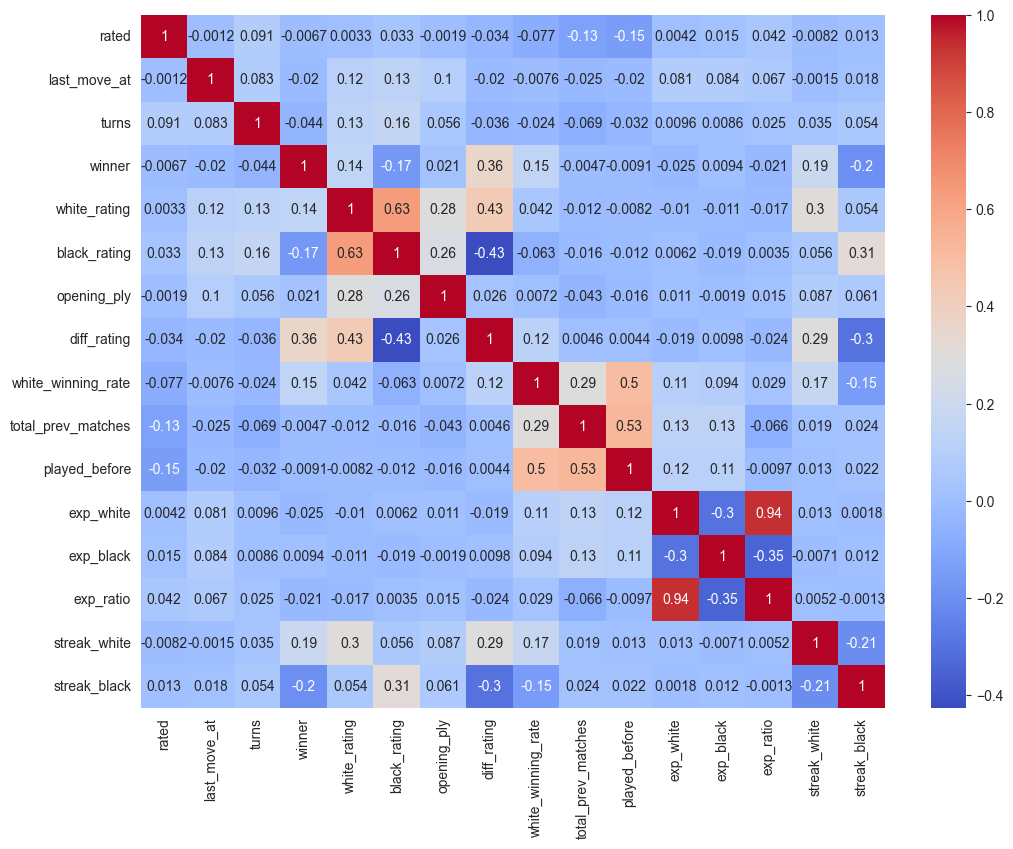

In [30]:
plt.figure(figsize=(12, 9))  # ancho y alto en pulgadas
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.show()

## Primer model

Fem un primer model amb les dades que sabem prèviament al començament de la partida

In [31]:
#explanatory_variables = ['rated', 'diff_rating', 'white_prev_wins_vs_black', 'black_prev_wins_vs_white', 'played_before', 'white_rating', 'black_rating']
explanatory_variables = ['rated', 'diff_rating', 'white_winning_rate', 'total_prev_matches', 'white_rating', 'black_rating', 'exp_ratio']

target_variable = "winner"

X = df[explanatory_variables]
y = df[target_variable]  # 1 = white, -1 = black, 0 = draw

# Opcional: quitar draws si quieres clasificar solo victoria de blanco/negro
X = X[y != 0]
y = y[y != 0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

logistic = LogisticRegression(max_iter=1000).fit(X_train, y_train)

yhat_log = logistic.predict(X_test)
print("Accuracy:", accuracy_score(y_test, yhat_log))

Accuracy: 0.663526949241235


In [32]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier()

# Entrenamiento
gb.fit(X_train, y_train)

# Predicción
y_pred = gb.predict(X_test)

# Evaluación
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.6682365253793825


In [33]:
df

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,...,diff_rating,white_winning_rate,total_prev_matches,played_before,exp_white,exp_black,exp_ratio,streak_white,streak_black,opening_group
10854,hmdl0w8w,False,2013-08-17 20:33:53.173,1.376772e+12,19,resign,1,12+8,julito,899,...,-240,0.0,0,0,0,0,0.00000,0,0,C
10853,6trard8c,True,2013-08-17 20:37:48.314,1.376772e+12,43,mate,1,7+15,kiii,1500,...,281,0.0,0,0,1,0,1.00000,-1,0,B
10852,2hf0bf3b,True,2013-08-19 16:38:07.783,1.376931e+12,27,resign,1,10+20,goldenfork,1381,...,-194,0.0,0,0,0,2,0.00000,0,0,C
10851,63x6m6fx,False,2013-08-19 17:23:45.599,1.376934e+12,84,resign,-1,10+8,kiii,1170,...,370,0.0,0,0,3,0,3.00000,-1,0,C
10850,rk7l19ti,True,2013-08-19 20:56:29.445,1.376947e+12,51,mate,1,20+15,kiii,1348,...,165,0.0,0,0,4,0,4.00000,-2,0,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13682,qCmTWffu,True,2017-09-04 01:27:41.297,1.504489e+12,55,mate,1,10+0,networkchess2,1940,...,93,0.0,0,0,38,0,38.00000,2,0,D
16582,5JxE5a6e,True,2017-09-04 01:28:53.111,1.504489e+12,61,mate,1,10+0,elijahreese,1871,...,415,0.0,0,0,14,0,14.00000,0,0,A
16581,8Xr8Hmp7,True,2017-09-04 01:41:20.676,1.504490e+12,48,resign,-1,10+0,elijahreese,1873,...,-40,0.0,0,0,15,0,15.00000,1,0,C
19463,dGvzzC9L,True,2017-09-04 02:30:59.427,1.504493e+12,67,resign,1,10+0,samoo1477,1754,...,-81,0.0,0,0,46,2,23.00000,1,0,C
